In [1]:
import pandas as pd
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def Food_group_sum (data, f_group):
    filt_data= data.loc[data.Food_group == f_group,:]
    data_grouped= filt_data.groupby(['Food_group','unit','origin_country','destin_country','year'])
    filt_data.loc[:,'value']= data_grouped.value.transform('sum')
    filt_data.loc[:,'item']= f_group
    return(filt_data)

def FoodEx_aggregation (data):
    food_groups = data.Food_group.unique() 

    # Iterate per food group
    data_fg= Food_group_sum(data,food_groups[0])
    
    for f in tqdm(food_groups[1:]): 
        data_fg= pd.concat([data_fg, Food_group_sum(data,f)], ignore_index=True)

    data_out = data_fg.drop_duplicates()
    return data_out.drop(columns='item')


In [3]:
#year_check= 2019 #'1986-1988'#2019
direction = ''
group_class = 'Food_group' # item
#data_og = pd.read_pickle('../Data/Data_year_groups_12.pkl')

country_metadata = pd.read_pickle('../Data/Country_info.pkl')

data_og = pd.read_pickle('../Data/Data_food_groups.pkl')

In [4]:
# Agregate data in the selected group_class:
if group_class == 'Food_group':
    data_og = FoodEx_aggregation(data_og)
    data_og = data_og.sort_values(by=['Food_group','year']).reset_index()
else:
    data_og['Food_group'] = data_og['item'] #need to fix
data_og

100%|██████████| 20/20 [00:59<00:00,  2.99s/it]


,index,destin_country_ISO,origin_country_ISO,year,unit,value,origin_country,destin_country,L1_foodex,Food_group
0,27358957,CI,FR,1986,tonnes,1.0,France,Côte d'Ivoire,A04PE,Confectionery including chocolate
1,27358972,CI,FR,1986,1000 US$,5.0,France,Côte d'Ivoire,A04PE,Confectionery including chocolate
2,27359023,CI,HK,1986,tonnes,4.0,"China, Hong Kong SAR",Côte d'Ivoire,A04PE,Confectionery including chocolate
3,27359024,CI,HK,1986,1000 US$,8.0,"China, Hong Kong SAR",Côte d'Ivoire,A04PE,Confectionery including chocolate
4,27359113,CI,TH,1986,tonnes,12.0,Thailand,Côte d'Ivoire,A04PE,Confectionery including chocolate
...,...,...,...,...,...,...,...,...,...,...
6846474,26128920,NP,US,2021,1000 US$,0.0,United States of America,Nepal,A03DJ,Water and water-based beverages
6846475,26128984,NP,AE,2021,tonnes,0.0,United Arab Emirates,Nepal,A03DJ,Water and water-based beverages
6846476,26128994,NP,AE,2021,1000 US$,0.0,United Arab Emirates,Nepal,A03DJ,Water and water-based beverages
6846477,26129033,NP,CA,2021,tonnes,1.0,Canada,Nepal,A03DJ,Water and water-based beverages


In [40]:
def Agregated_network (edge_data,node_info, food_item):
    edge_data = edge_data.loc[(edge_data.unit =='1000 US$') &(edge_data.Food_group ==food_item)  & (edge_data.year == 2019) & (edge_data.value > 0) ,:].copy()

    # General network 
    pos_dict = node_info.loc[:,['ISO','pos','name']].set_index('ISO').to_dict(orient='index')
    pos_dict

    edge_dict =dict(zip(zip(edge_data['origin_country_ISO'], edge_data['destin_country_ISO']), edge_data['value']))
    edge_dict

    # Create network
    G=nx.DiGraph()

    G.add_nodes_from(pos_dict)
    nx.set_node_attributes(G,pos_dict)

    G.add_edges_from(edge_dict.keys())
    nx.set_edge_attributes(G, edge_dict, 'weight')
    return G

data_filt = data_og.loc[(data_og.unit =='1000 US$')  & (data_og.year == 2019) & (data_og.value > 0) ,:].copy()

foods_list= data_filt.Food_group.unique()
foods_list

short_path = list()
diameter = list()

for food_item in tqdm(foods_list):
    G = Agregated_network(data_og, country_metadata, food_item)
    cc = max(nx.strongly_connected_components(G), key=len)
    #test_t= [len(i) for i in nx.strongly_connected_components(G)]
    #print(test_t)
    S= G.subgraph(cc).copy()
    short_path.append(nx.average_shortest_path_length(S,weight=True ))
    diameter.append(nx.diameter(S,weight=False))


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


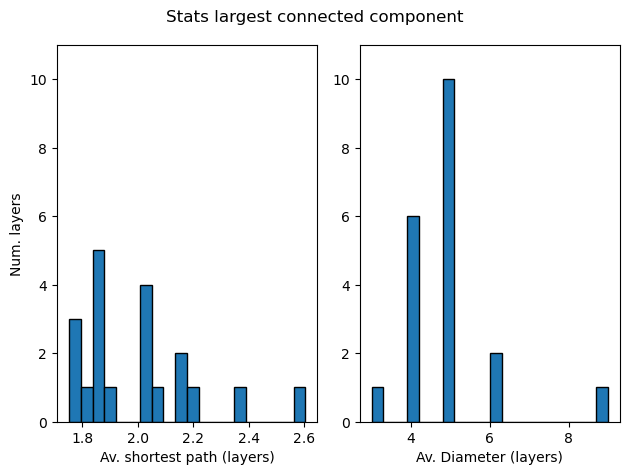

In [55]:
fig,ax = plt.subplots(1,2)
ax[0].hist(short_path, bins=20, edgecolor= 'black')  # Adjust the number of bins as needed
ax[1].hist(diameter, bins=20, edgecolor= 'black')  # Adjust the number of bins as needed

plt.suptitle('Stats largest connected component')
ax[0].set_xlabel('Av. shortest path (layers)')
ax[0].set_ylim([0,11])
ax[1].set_ylim([0,11])

ax[0].set_ylabel('Num. layers')
ax[1].set_xlabel('Av. Diameter (layers)')
plt.tight_layout()
plt.savefig('../Plots/stats_connected_comp.pdf')

In [53]:
diameter

[6, 5, 5, 4, 4, 9, 6, 4, 4, 5, 5, 5, 5, 5, 3, 5, 4, 5, 5, 4]

In [26]:
print('Average shortest path across all layers: ',np.average(short_path))
print('Average diameter across all layers: ', np.average(diameter))

Average shortest path across all layers:  2.000926164221137
Average diameter across all layers:  4.9


In [27]:
# Degree estimations
out_degree= pd.DataFrame([i for i in S.out_degree()],columns=['country','out_deg']).sort_values(by='out_deg',ascending=False)
in_degree= pd.DataFrame([i for i in S.in_degree()],columns=['country','in_deg']).sort_values(by='in_deg',ascending=False)

# Overlap: sum of weights (out_degree)
overlap= pd.DataFrame([i for i in S.out_degree(weight='weight')],columns=['country','out_overl']).sort_values(by='out_overl',ascending=False)
in_overlap= pd.DataFrame([i for i in S.in_degree(weight='weight')],columns=['country','in_overl']).sort_values(by='in_overl',ascending=False)

overlap= pd.merge(overlap, in_overlap, on='country', copy=False)
overlap= pd.merge(overlap, out_degree, on='country', copy=False)
overlap= pd.merge(overlap, in_degree, on='country', copy=False)
overlap

,country,out_overl,in_overl,out_deg,in_deg
0,AT,3205745.0,884545.0,154,56
1,DE,1930010.0,1516570.0,158,100
2,CH,1889418.0,389989.0,104,81
3,NL,1760870.0,1046495.0,160,93
4,TH,1738698.0,52079.0,136,47
...,...,...,...,...,...
175,ER,2.0,64.0,1,5
176,CV,1.0,4389.0,1,21
177,KM,1.0,5386.0,1,27
178,KI,1.0,568.0,1,14
